<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
This is a notebook to describe the step by step logic of training a GP-VAE
</div>

VAEs dynamiques : https://arxiv.org/abs/2008.12595

Papiers GP-VAE :
- Deep Probabilistic Time Series Imputation https://arxiv.org/abs/1907.04155
- Gaussian Process Prior Variational Autoencoders : https://arxiv.org/abs/1810.11738
- Bayesian Gaussian Process Latent Variable Model : https://proceedings.mlr.press/v9/titsias10a/titsias10a.pdf
- Markovian Gaussian Process Variational Autoencoders : https://arxiv.org/abs/2207.05543

Imports and set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import sys
import os

# Add the parent directory to sys.path to find the libs module
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
# print(f"Added {parent_dir} to Python path")
# print(f"Current working directory: {os.getcwd()}")
# print(f"Python path: {sys.path}")

In [3]:
# Set seed for reproducibility

from libs.gpvae_lib import seed_everything
seed_everything(42)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


### Synthetic data

We assume here a batch of $B$ time series, each composed of $N$ points $x \in \mathbb{R}^{D_x}$.

We will use a set of $D_z$ Gaussian Processes to encode the latent representation.

In [5]:
# Dimensions
Dx = 4
Dz = 1

# parameters
N = 200
B = 1

In [6]:
# Synthetic data
x = torch.randn((B,N,Dx)).to(device)
t = torch.linspace(0, 1, N).to(device).unsqueeze(0).repeat(B, 1)

# report
print(f"batch size: {B}")
print(f"time series length: {N}")
print(f"Dx: {Dx}, Dz: {Dz}")
print(f"x shape: {x.shape}")
print(f"t shape: {t.shape}")

batch size: 1
time series length: 200
Dx: 4, Dz: 1
x shape: torch.Size([1, 200, 4])
t shape: torch.Size([1, 200])


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Generative model
</div>

In [7]:
# Utility function to create a Multi-Layer Perceptron (MLP)

def make_mlp(
    input_dim, 
    output_dim, 
    n_layers=3, 
    inter_dim=128, 
    activation=nn.ReLU):
    """Create a Multi-Layer Perceptron (MLP) with specified parameters.
    
    Args:
        input_dim (int): Dimension of the input layer.
        output_dim (int): Dimension of the output layer.
        n_layers (int, optional): Number of layers in the MLP. Defaults to 3.
            - first layer is input_dim x inter_dim
            - last layer is inter_dim x output_dim
            - all other layers are inter_dim x inter_dim
        inter_dim (int, optional): Number of neurons in the hidden layers. Defaults to 128.
        activation (nn.Module, optional): Activation function to use. Defaults to nn.ReLU.
            the last layer does not have an activation function.
        
    Returns:
        nn.Sequential: A sequential model representing the MLP.
    """
    
    layers = []
    for i in range(n_layers):
        if i == 0:
            layers.append(nn.Linear(input_dim, inter_dim))
        elif i == n_layers - 1:
            layers.append(nn.Linear(inter_dim, output_dim))
        else:
            layers.append(nn.Linear(inter_dim, inter_dim))
        
        if i < n_layers - 1:
            layers.append(activation())
    
    return nn.Sequential(*layers)

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Encoder
</div>

For a given time serie, the approximate posterior $q_{\phi}$ is a set of $D_z$ independent -but not identical- multivariate Gaussians of dimension $N$. 

This encodes a temporal dependency over each dimension of the latent variables, but no dependency between dimensions.

$q_{\phi}$ is a tf.distribution.MultivariateNormal object with batch_shape = $(B, D_z)$ and event_shape = ($N$)

\begin{align}
q_{\phi}(z_{1:N} \vert x_{1:N}) &= \mathcal{N}(\mu_{\phi}(z_{1:N} \vert x_{1:N}), \Sigma_{\phi}(z_{1:N} \vert x_{1:N}))
\end{align}

### Encoder mean

We output the mean $\mu_{\phi}(z_{1:N} \vert x_{1:N})$ of $q_{\phi}$ with a simple MLP.

The neural net takes an input tensor $(B, N, D_x)$ and outputs a tensor $(B, D_z, N)$ - note the permutation between $D_z$ and $N$.

In [8]:
class EncoderMean(nn.Module):
    """ Neural Net to compute the mean of the Gaussian Encoder distribution.
    """
    
    def __init__(self,
                 x_dimension = 1,
                 z_dimension = 1,
                 n_layers = 3,
                 inter_dim = 128,
                 activation = nn.ReLU,
                 ):
        """_summary_

        Args:
            x_dimension (_type_, optional): Dimension des observations. Defaults to 1.
            z_dimension (_type_, optional): Dimension de l'espace latent. Defaults to 1.
            n_layers (int, optional): Nombre total de layers du MLP. Defaults to 3.
            inter_dim (int, optional): Nombre de neurones des hidden layers. Defaults to 128.
            activation (_type_, optional): Activation. Defaults to nn.ReLU. NB : la dernière couche n'a pas d'activation.
        """
        super(EncoderMean, self).__init__()
        
        assert n_layers > 0, "n_layers must be greater than 0 !"
        
        self.x_dimension = int(x_dimension)
        self.z_dimension = int(z_dimension)
        self.n_layers = int(n_layers)
        self.inter_dim = int(inter_dim)
        self.activation = activation
                
        self.mlp = make_mlp(
            input_dim=self.x_dimension,
            output_dim=self.z_dimension,  # output is a vector of length sequence_length * z_dimension
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=self.activation
        )
        
    
    def forward(self, input):
        """
        Forward pass of the EncoderMean.
        Args:
            x (torch.Tensor): Input tensor (..., N, x_dimension) (possibly N=1, ie a single point)
        Returns:
            z (torch.Tensor): Output tensor (..., z_dimension, N)
        """
        
        assert input.size(-1) == self.x_dimension, f"Wrong x_dim in EncoderMean. Input tensor must have shape (..., {self.x_dimension})"
        assert input.dim() >= 2, "Input tensor must have at least 2 dimensions (sequence_length -possibly 1- and x_dimension)"
        
        output = self.mlp(input)  # (..., N, Dz)
        output = torch.transpose(output,-1, -2)  # (..., Dz, N)
            
        return output  # (..., Dz, N) : batch of Dz independent but not identical Gaussians of dimension N. (can have N=1).
    
    def __repr__(self):
        return (f"{self.__class__.__name__}, "
                f"x_dimension={self.x_dimension}, z_dimension={self.z_dimension}, "
                f"n_layers={self.n_layers}, inter_dim={self.inter_dim}, "
                f"activation={self.activation.__name__}")

In [9]:
encoder_mean = EncoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

print(f"Encoder mean function: {encoder_mean}")

mu_phi = encoder_mean(x)

# report
print(f"Encoder input shape : (B,N,Dx) = {x.shape}")
print(f"Encoder mean output mu_phi shape : (B,Dz,N) = {mu_phi.shape}")

Encoder mean function: EncoderMean, x_dimension=4, z_dimension=1, n_layers=2, inter_dim=32, activation=ReLU
Encoder input shape : (B,N,Dx) = torch.Size([1, 200, 4])
Encoder mean output mu_phi shape : (B,Dz,N) = torch.Size([1, 1, 200])


### Parametrizing the Gaussian Encoder with either precision matrix or covariance matrix

We have the choice of parametrizing $q_{\phi}$ with covariance matrices, precision matrices, of Cholesky-lower triangular matrices.

Precision matrices are formed following Deep Probabilistic Time Series Imputation https://arxiv.org/abs/1907.04155 :

First, a bi-band upper triangular matrix $B$ is formed as the sum of a diagonal matrix $D$ (with $D_{ii} > 0$) and a upper-band matrix $U = U_{ij}$ with $U_{ij} = u_{ij}$ if $j \in [i, i+1]$. 

Then the precision matrix is assembled by $\Lambda = B^TB$ (this ensures positive definitiveness)

We output a batch of precision matrices of shape $(B, Dz, N, N)$

In [10]:
# Encoder Precision

class EncoderPrecision(nn.Module):
    """Reprise de l'implémentation du papier GPVAE avec
    matrice de précision triangulaire supérieure à deux bandes
    """
    
    def __init__(self,
                 x_dimension = 1,
                 z_dimension = 1,
                 n_layers = 2,
                 inter_dim = 32,
                 activation = nn.ReLU,
                 epsilon = 1e-3
                 ):
        
        super(EncoderPrecision, self).__init__()
        
        self.x_dimension = int(x_dimension)
        self.z_dimension = int(z_dimension)
        self.n_layers = int(n_layers)
        self.inter_dim = int(inter_dim)
        self.activation = activation
        self.epsilon = float(epsilon) 
        
        self.diagonal_mlp = make_mlp(
            input_dim=self.x_dimension,
            output_dim=self.z_dimension,
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=activation
        )
        
        self.off_diagonal_mlp = make_mlp(
            input_dim=self.x_dimension,
            output_dim=self.z_dimension,
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=activation
        )
        
    def forward(self, x):
        """
        x : (B, N, Dx)
        return : (B, Dz, Dz)
        """
        N = x.size(-2)
        
        # Compute the diagonal part
        D = self.diagonal_mlp(x) # (B, N, Dz)
        D = torch.transpose(D, -1, -2)  # (B, Dz, N)
        D = torch.exp(D) # ensure > 0
        D = torch.diag_embed(D) # (B, Dz, N, N)
        
        # compute the upper band
        U = self.off_diagonal_mlp(x) # (B, N, Dz)
        U = torch.transpose(U, -1, -2)  # (B, Dz, N)
        U = torch.diag_embed(U[...,:-1], offset=1)  # (B, Dz, N, N)
        
        # Combine diagonal and upper band
        B = D + U # (B, Dz, N, N)

        precision_matrix = torch.transpose(B, -1, -2) @ B  # (B, N, Dz, Dz)        
        # Add epsilon to the diagonal to ensure PSD numerical stability
        epsilon_matrix = self.epsilon * torch.eye(N, device=device) # (N, N)
        precision_matrix = precision_matrix + epsilon_matrix # (B, Dz, N, N) with epsilon broacasted
        
        return D, B, precision_matrix  # (B, Dz, N, N)
    
    def __repr__(self):
        return (f"{self.__class__.__name__}(x_dimension={self.x_dimension}, "
                f"z_dimension={self.z_dimension}, n_layers={self.n_layers}, "
                f"inter_dim={self.inter_dim}, activation={self.activation.__name__}, "
                f"epsilon={self.epsilon})")

In [11]:
encoder_precision = EncoderPrecision(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

D, B, precision_matrix_q_phi = encoder_precision(x)

print(f"EncoderPrecision: {encoder_precision}")
print()
print(f"batch size = {x.size(0)}")
print(f"longueur de la séquence = {x.size(1)}")
print(f"Dimension de l'entrée x = {x.size(-1)}")
print(f"Dimension de l'espace latent z = {Dz}")
print()
print(f"Input x shape: {x.shape}")  # (B, N, Dx)
print(f"Batch matrices diagonales D, shape (B,Dz,N,N): {D.shape}")  # (B, Dz, N, N)
print(f"Batch matrices bi-bandes B, shape (B,Dz,N,N): {B.shape}")  # (B, Dz, N, N)
print(f"Batch matrices precision, shape (B,Dz,N,N): {precision_matrix_q_phi.shape}")  # (B, Dz, N, N)

EncoderPrecision: EncoderPrecision(x_dimension=4, z_dimension=1, n_layers=2, inter_dim=32, activation=ReLU, epsilon=0.001)

batch size = 1
longueur de la séquence = 200
Dimension de l'entrée x = 4
Dimension de l'espace latent z = 1

Input x shape: torch.Size([1, 200, 4])
Batch matrices diagonales D, shape (B,Dz,N,N): torch.Size([1, 1, 200, 200])
Batch matrices bi-bandes B, shape (B,Dz,N,N): torch.Size([1, 1, 200, 200])
Batch matrices precision, shape (B,Dz,N,N): torch.Size([1, 1, 200, 200])


Covariance matrices are formed by using the Cholesky decomposition, $C = LL^T$, with $L$ lower traingular with stricly positive entries on the diagonal.

In [12]:
# Encoder Covariance

class EncoderCovariance(nn.Module):
    """ Neural Net to compute the covariance of the Gaussian Encoder distribution.
    Uses a MLP to compute the lower triangular matrix of the Cholesky decomposition of the covariance matrix.
    L is triangular inferior, with diagonal elements strictly positive.
    """
    
    def __init__(self,
                 x_dimension = 1,
                 z_dimension = 1,
                 n_layers = 3,
                 inter_dim = 128,
                 activation = nn.ReLU,
                 epsilon = 1e-3,  # small positive constant to ensure positive definiteness of the kernel matrix
                 ):
        """_summary_

        Args:
            x_dimension (_type_, optional): Dimension des observations. Defaults to 1.
            z_dimension (_type_, optional): Dimension de l'espace latent. Defaults to 1.
            n_layers (int, optional): Nombre total de layers du MLP. Defaults to 3.
            inter_dim (int, optional): Nombre de neurones des hidden layers. Defaults to 128.
            activation (_type_, optional): Activation. Defaults to nn.ReLU. NB : la dernière couche n'a pas d'activation.
        """
        super(EncoderCovariance, self).__init__()
        
        assert n_layers > 0, "n_layers must be greater than 0 !"
        
        self.x_dimension = int(x_dimension)
        self.z_dimension = int(z_dimension)
        self.n_layers = int(n_layers)
        self.inter_dim = int(inter_dim)
        self.activation = activation
        self.epsilon = float(epsilon)  # small positive constant to ensure positive definiteness of the kernel matrix
        
        # this network to get the diagonal elements of the covariance matrix
        self.diagonal_mlp = make_mlp(
            input_dim=self.x_dimension,
            output_dim=self.z_dimension,
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=activation
        )
        
        # this network to get Dz elements that will be the lower triangular part (without the diagonal) of the covariance matrix                
        self.full_matrix_mlp = make_mlp(
            input_dim=self.x_dimension,
            output_dim=self.z_dimension,
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=activation
        )
        
    
    def forward(self, x):
        """
        Forward pass of the EncoderCovariance.
        Args:
            x (torch.Tensor): Input tensor (..., N, x_dimension) 
                - N can be 1 (ie a single point) or the sequence length. Must be specified.

        Returns:
            L (torch.Tensor): Lower triangular matrix of shape (..., z_dimension, N, N) 
                L can be used as scale_tril in tf.distributions.MultivariateNormal
            C (torch.Tensor): Covariance matrix of shape (..., z_dimension, N, N) 
                C can be used as covariance_matrix in tf.distributions.MultivariateNormal. but this creates lots of numerical instabilities.
            C is computed as L @ L^T, where L is the lower triangular matrix. (Cholesky decomposition)
        """
        
        # basic check of shape of input x
        assert x.size(-1) == self.x_dimension, f"Wrong x_dim in EncoderCovariance. Input tensor must have shape (batch_size, {self.sequence_length}, {self.x_dimension}) or ({self.sequence_length}, {self.x_dimension})"
        assert x.dim() >= 2, "Input tensor must have at least 2 dimensions (sequence_length -possibly 1- and x_dimension)"
        
        # input is a tensor of shape (..., N, Dx)
        N = x.size(-2)  # sequence length
        
        # Compute the diagonal elements of the covariance matrix
        D = self.diagonal_mlp(x)  # out : (..., N, Dz)
        D = torch.transpose(D, -1, -2)  # out : (..., Dz, N)
        D = torch.exp(D) # out : (..., Dz, N). Ensure entries > 0.
        D = torch.diag_embed(D) # shape (..., Dz, N, N)
        
        # Get the elements outside the diagonal
        M = self.full_matrix_mlp(x) # shape (..., N, Dz)
        M = torch.transpose(M, -1, -2)  # shape (..., Dz, N)
        M1 = M.unsqueeze(-1)  # shape (..., Dz, N, 1)
        M2 = M.unsqueeze(-2)  # shape (..., Dz, 1, N)
        M = torch.matmul(M1, M2)  # shape (..., Dz, N, N)
        M = torch.tril(M, diagonal=-1)  # Keep only the lower triangular part of the matrix (excluding the diagonal) (..., Dz, N, N))
        
        # Assemble the lower triangular matrix L
        L = D + M # (..., Dz, N, N)
        
        # Assemble the covariance matrix C
        C = L @ L.transpose(-1, -2)  # C = L @ L^T # (..., Dz, N, N)
        C = C + self.epsilon * torch.eye(N, device=x.device) # Add a small value to the diagonal for numerical stability (use broadcasting)
            
        return L, C # (..., Dz, N, N) Covariance matrix C
    
    def __repr__(self):
        return (f"{self.__class__.__name__} : "
                f"(x_dimension={self.x_dimension}, z_dimension={self.z_dimension}, "
                f"n_layers={self.n_layers}, inter_dim={self.inter_dim}, "
                f"activation={self.activation.__name__}, "
                f"epsilon (to ensure PSD)={self.epsilon:.3e})")

In [13]:
encoder_covariance = EncoderCovariance(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

L_q_phi, covariance_matrix_q_phi = encoder_covariance(x)

print(f"Encoder Covariance: {encoder_covariance}")
print()

print(f"batch size = {x.size(0)}")
print(f"longueur de la séquence = {x.size(1)}")
print(f"Dimension de l'entrée x = {x.size(-1)}")
print(f"Dimension de l'espace latent z = {Dz}")
print()

print(f"Input x shape (B,N,Dx): {x.shape}")  # (B, N, Dx)
print(f"Batch matrices triangulaires inférieures L, shape (B,Dz,N,N): {L_q_phi.shape}")  # (B, Dz, N, N)
print(f"Batch matrices covariance, shape (B,Dz,N,N): {covariance_matrix_q_phi.shape}")  # (B, Dz, N, N)

Encoder Covariance: EncoderCovariance : (x_dimension=4, z_dimension=1, n_layers=2, inter_dim=32, activation=ReLU, epsilon (to ensure PSD)=1.000e-03)

batch size = 1
longueur de la séquence = 200
Dimension de l'entrée x = 4
Dimension de l'espace latent z = 1

Input x shape (B,N,Dx): torch.Size([1, 200, 4])
Batch matrices triangulaires inférieures L, shape (B,Dz,N,N): torch.Size([1, 1, 200, 200])
Batch matrices covariance, shape (B,Dz,N,N): torch.Size([1, 1, 200, 200])


We can form the approximate posterior (encoder) with either parametrization.

In [14]:
#------- CHOIX 1 : PRECISION MATRIX -------
q_phi_p = torch.distributions.MultivariateNormal(
    loc=mu_phi,  # (Dz, N)
    precision_matrix=precision_matrix_q_phi,  # (Dz, N, N)
)

# ------- CHOIX 2 : COVARIANCE MATRIX -------
q_phi_c = torch.distributions.MultivariateNormal(
    loc=mu_phi,  # (Dz, N)
    scale_tril=L_q_phi,  # (Dz, N, N)
)

# ----- Summary de l'encoder q_phi -----
print(f"q_phi with precision matrix : {q_phi_p}")
print(f"\tq_phi batch shape: {q_phi_p.batch_shape}")
print(f"\tq_phi event shape: {q_phi_p.event_shape}")

print()
print(f"q_phi with Cholesky matrix : {q_phi_c}")
print(f"\tq_phi batch shape: {q_phi_c.batch_shape}")
print(f"\tq_phi event shape: {q_phi_c.event_shape}")

q_phi with precision matrix : MultivariateNormal(loc: torch.Size([1, 1, 200]), precision_matrix: torch.Size([1, 1, 200, 200]))
	q_phi batch shape: torch.Size([1, 1])
	q_phi event shape: torch.Size([200])

q_phi with Cholesky matrix : MultivariateNormal(loc: torch.Size([1, 1, 200]), scale_tril: torch.Size([1, 1, 200, 200]))
	q_phi batch shape: torch.Size([1, 1])
	q_phi event shape: torch.Size([200])


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Decoder
</div>

By D-separation, we know that the decoder factorizes :

\begin{align}
p_{\theta_x}(x_{1:N} \vert z_{1:N}) &= \prod_{i=1}^{N} p_{\theta_x}(x_i \vert z_i)
\end{align}

When the decoder is chosen to be Gaussian, each $p_{\theta_x}(x_i \vert z_i)$ is a Gaussian distribution of dimension $D_x$ with a covariance matrix that can be any PSD matrix (as there are correlations between dimensions of $x$) :

\begin{align}
p_{\theta_x} (x_{i} \vert z_{i}) &= \mathcal{N}(\mu_{\theta_x}(x_{i} \vert z_{i}), (\Sigma_{\theta_x}(x_{i} \vert z_{i})))
\end{align}

We learn $\mu_{\theta_x}$ and $\Sigma_{\theta_x}$ with two MLPs.

In [15]:
class DecoderMean(nn.Module):
    """ Neural Net to compute the mean of the Gaussian Decoder distribution.
    """
    
    def __init__(self,
                 x_dimension = 1,
                 z_dimension = 1,
                 n_layers = 3,
                 inter_dim = 128,
                 activation = nn.ReLU,
                 ):
        """_summary_

        Args:
            x_dimension (_type_, optional): Dimension des observations. Defaults to 1.
            z_dimension (_type_, optional): Dimension de l'espace latent. Defaults to 1.
            n_layers (int, optional): Nombre total de layers du MLP. Defaults to 3.
            inter_dim (int, optional): Nombre de neurones des hidden layers. Defaults to 128.
            activation (_type_, optional): Activation. Defaults to nn.ReLU. NB : la dernière couche n'a pas d'activation.
        """
        super(DecoderMean, self).__init__()
        
        assert n_layers > 0, "n_layers must be greater than 0"
        
        self.x_dimension = int(x_dimension)
        self.z_dimension = int(z_dimension)
        self.n_layers = int(n_layers)
        self.inter_dim = int(inter_dim)
        self.activation = activation
        
        self.mlp = make_mlp(
            input_dim=z_dimension,
            output_dim=x_dimension,
            n_layers=n_layers,
            inter_dim=inter_dim,
            activation=activation
        )
    
    def forward(self, z):
        """
        Forward pass of the DecoderMean.
        Args:
            z (torch.Tensor): Input tensor of shape (..., z_dimension)
        Returns:
            torch.Tensor: mu_x : Output tensor of shape (..., x_dimension)
        """
              
        # mini check
        assert z.size(-1) == self.z_dimension, f"Incorrect latent dim. Input tensor z must have shape (..., {self.z_dimension})"
            
        return self.mlp(z)  # (..., Dx)
    
    def __repr__(self):
        return (f"{self.__class__.__name__} "
                f"x_dimension={self.x_dimension}, z_dimension={self.z_dimension}, "
                f"n_layers={self.n_layers}, inter_dim={self.inter_dim}, "
                f"activation={self.activation.__name__}")

In [16]:
decoder_mean = DecoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=16,
    activation=nn.ReLU,
).to(device)

print(decoder_mean)

z = q_phi_c.sample()  # (B, Dz, N)
print()
print(f"z shape when sampled : {z.shape}")  # (B, Dz, N)
print(f"Note that we need to permute the last two dimensions of z to match the decoder_mean input shape (B, N, Dz)")

z = z.permute(0, 2, 1)  # (B, N, Dz) to match the decoder input shape
print(f"z shape after permutation for decoding : {z.shape}")  # (B, N, Dz)
decoder_mean_output = decoder_mean(z)  # (B, N, Dx)
# decoder_mean_output = decoder_mean_output.transpose(-1,-2)  # (B, Dx, N) to match the output shape

print()
print(f"decoder_mean_output shape (B,N,Dx): {decoder_mean_output.shape}")  # (B, Dx, N)

DecoderMean x_dimension=4, z_dimension=1, n_layers=2, inter_dim=16, activation=ReLU

z shape when sampled : torch.Size([1, 1, 200])
Note that we need to permute the last two dimensions of z to match the decoder_mean input shape (B, N, Dz)
z shape after permutation for decoding : torch.Size([1, 200, 1])

decoder_mean_output shape (B,N,Dx): torch.Size([1, 200, 4])


We get the decoder covariance matrix $D_x \times D_x$ as we did for the encoder covariance matrix (ie via bi-bande-based precision matrix or Cholesky-based covariance matrix)

In [17]:
# Decoder Covariance

class DecoderCovariance(nn.Module):
    """ Neural Net to compute the covariance of the Gaussian Encoder distribution.
    Uses a MLP to compute the lower triangular matrix of the Cholesky decomposition of the covariance matrix.
    L is triangular inferior, with diagonal elements strictly positive.
    """
    
    def __init__(self,
                 x_dimension = 1,
                 z_dimension = 1,
                 n_layers = 3,
                 inter_dim = 128,
                 activation = nn.ReLU,
                 epsilon = 1e-3,  # small positive constant to ensure positive definiteness of the kernel matrix
                 ):
        """_summary_

        Args:
            x_dimension (_type_, optional): Dimension des observations. Defaults to 1.
            z_dimension (_type_, optional): Dimension de l'espace latent. Defaults to 1.
            n_layers (int, optional): Nombre total de layers du MLP. Defaults to 3.
            inter_dim (int, optional): Nombre de neurones des hidden layers. Defaults to 128.
            activation (_type_, optional): Activation. Defaults to nn.ReLU. NB : la dernière couche n'a pas d'activation.
        """
        super(DecoderCovariance, self).__init__()
        
        assert n_layers > 0, "n_layers must be greater than 0 !"
        
        self.x_dimension = int(x_dimension)
        self.z_dimension = int(z_dimension)
        self.n_layers = int(n_layers)
        self.inter_dim = int(inter_dim)
        self.activation = activation
        self.epsilon = float(epsilon)  # small positive constant to ensure positive definiteness of the kernel matrix
        
        # this network to get the diagonal elements of the covariance matrix
        self.diagonal_mlp = make_mlp(
            input_dim=self.z_dimension,
            output_dim=self.x_dimension,
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=activation
        )
        
        # this network to get Dz elements that will be the lower triangular part (without the diagonal) of the covariance matrix                
        self.full_matrix_mlp = make_mlp(
            input_dim=self.z_dimension,
            output_dim=self.x_dimension,
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=activation
        )
    
    def forward(self, z):
        """
        Forward pass of the EncoderCovariance.
        Args:
            z (torch.Tensor): Input tensor (..., N, z_dimension) 
                - N can be 1 (ie a single point) or the sequence length. Must be specified.

        Returns:
            L (torch.Tensor): Lower triangular matrix of shape (..., N, x_dimension, x_dimension) 
                L can be used as scale_tril in tf.distributions.MultivariateNormal
            C (torch.Tensor): Covariance matrix of shape (..., N, x_dimension, x_dimension) 
                C can be used as covariance_matrix in tf.distributions.MultivariateNormal. but this creates lots of numerical instabilities.
            C is computed as L @ L^T, where L is the lower triangular matrix. (Cholesky decomposition)
        """
        
        # basic check of shape of input x
        assert z.size(-1) == self.z_dimension, f"Wrong z_dim in DecoderCovariance. Input tensor must have shape (batch_size, {self.sequence_length}, {self.z_dimension}) or ({self.sequence_length}, {self.z_dimension})"
        assert z.dim() >= 2, "Input tensor must have at least 2 dimensions (sequence_length -possibly 1- and x_dimension)"
        
        # input is a tensor of shape (..., N, Dx)
        N = z.size(-2)  # sequence length
        
        # Compute the diagonal elements of the covariance matrix
        D = self.diagonal_mlp(z)  # out : (..., N,Dx)
        D = torch.exp(D) # out : (..., N,Dx). Ensure entries > 0.
        D = torch.diag_embed(D) # shape (...,N,Dx,Dx)
        
        # Get the elements outside the diagonal
        M = self.full_matrix_mlp(z) # shape (..., N,Dx)
        M1 = M.unsqueeze(-1)  # shape (...,N,Dx,1)
        M2 = M.unsqueeze(-2)  # shape (...,N,1,Dx)
        M = torch.matmul(M1, M2)  # shape (..., N,Dx,DX)
        # Keep only the lower triangular part of the matrix (excluding the diagonal)
        M = torch.tril(M, diagonal=-1)  # (...,N,Dx,Dx)
        
        # Assemble the lower triangular matrix L
        L = D + M # (...,N,Dx,Dx)
        
        # Assemble the covariance matrix C
        C = L @ L.transpose(-1, -2)  # C = L @ L^T # (...,N,Dx,Dx)
        C = C + self.epsilon * torch.eye(self.x_dimension, device=x.device) # Add a small value to the diagonal for numerical stability (use broadcasting)
        
        return L, C # (..., Dz, N, N) Covariance matrix C
    
    def __repr__(self):
        return (f"{self.__class__.__name__} : "
                f"(x_dimension={self.x_dimension}, z_dimension={self.z_dimension}, "
                f"n_layers={self.n_layers}, inter_dim={self.inter_dim}, "
                f"activation={self.activation.__name__}, "
                f"epsilon (to ensure PSD)={self.epsilon:.3e})")

In [18]:
decoder_covariance = DecoderCovariance(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

print(decoder_covariance)

z = q_phi_c.sample()  # (B, Dz, N)

print()
print(f"z shape when sampled (B,Dz,N): {z.shape}")  # (B, Dz, N)
z = z.permute(0, 2, 1)  # (B, N, Dz) to match the decoder input shape
print(f"Note that we need to permute the last two dimensions of z to match the decoder_mean input shape (B, N, Dz)")
print(f"z shape after permutation for decoding (B,N,Dz): {z.shape}")  # (B, N, Dz)

L, decoder_covar_output = decoder_covariance(z)  # (B,N,Dx,Dx)

print()
print(f"decoder_covar_output shape (B,N,Dx,Dx): {decoder_covar_output.shape}")  # (B,N,Dx,Dx)

DecoderCovariance : (x_dimension=4, z_dimension=1, n_layers=2, inter_dim=32, activation=ReLU, epsilon (to ensure PSD)=1.000e-03)

z shape when sampled (B,Dz,N): torch.Size([1, 1, 200])
Note that we need to permute the last two dimensions of z to match the decoder_mean input shape (B, N, Dz)
z shape after permutation for decoding (B,N,Dz): torch.Size([1, 200, 1])

decoder_covar_output shape (B,N,Dx,Dx): torch.Size([1, 200, 4, 4])


We form the decoder with a multivariate normal distribution

In [19]:
mu_x = decoder_mean_output  # (B,N,Dx)
print(f"mu_x shape (B,N,Dx): {mu_x.shape}")

covar_x = decoder_covar_output  # (B,N,Dx,Dx)
print(f"covar_x shape (B,N,Dx,Dx): {covar_x.shape}")

p_theta_x = torch.distributions.MultivariateNormal(
    loc=mu_x,
    covariance_matrix=covar_x
)

print(f"p_theta_x: {p_theta_x}")
print(f"\tp_theta_x batch shape (B,Dx): {p_theta_x.batch_shape}") # (B,Dx)
print(f"\tp_theta_x event shape (N): {p_theta_x.event_shape}") # (N,)

mu_x shape (B,N,Dx): torch.Size([1, 200, 4])
covar_x shape (B,N,Dx,Dx): torch.Size([1, 200, 4, 4])
p_theta_x: MultivariateNormal(loc: torch.Size([1, 200, 4]), covariance_matrix: torch.Size([1, 200, 4, 4]))
	p_theta_x batch shape (B,Dx): torch.Size([1, 200])
	p_theta_x event shape (N): torch.Size([4])


We will actually instantiate several ($K$) distributions $p_{\theta_x}$ by sampling $K$ times $z_{1:N}$, so we can average the reconstruction loss.

In [20]:
K = 100  # Number of samples to average the reconstruction loss
z_sampled = q_phi_c.sample((K,))  # (K,B,Dz,N)

print(f"z shape when sampled K={K} times (K,B,Dz,N): {z_sampled.shape}")  # (K, B, Dz, N)
z_sampled_p = z_sampled.transpose(-1, -2)
print(f"Permuting the last two dimensions of z to match the decoder covariance input shape (K,B,N,Dz)")
print(f"z shape after permutation for decoding mean (K,B,N,Dz) : {z_sampled_p.shape}")  # (K, B, N, Dz)

mu_x = decoder_mean(z_sampled_p)  # (K,B,N,Dx)
print()
print(f"mu_x shape (K,B,N,Dx): {mu_x.shape}")

L_x, covar_x = decoder_covariance(z_sampled_p)  # (K,B,N,Dx,Dx)
print(f"covar_x shape (K,B,N,Dx,Dx): {covar_x.shape}")

p_theta_x = torch.distributions.MultivariateNormal(
    loc=mu_x,
    covariance_matrix=covar_x
)

print()
print(f"p_theta_x: {p_theta_x}")
print(f"\tp_theta_x batch shape (K,B,N): {p_theta_x.batch_shape}")  # (K, B, N)
print(f"\tp_theta_x event shape (Dx): {p_theta_x.event_shape}")  # (Dx,)

z shape when sampled K=100 times (K,B,Dz,N): torch.Size([100, 1, 1, 200])
Permuting the last two dimensions of z to match the decoder covariance input shape (K,B,N,Dz)
z shape after permutation for decoding mean (K,B,N,Dz) : torch.Size([100, 1, 200, 1])

mu_x shape (K,B,N,Dx): torch.Size([100, 1, 200, 4])
covar_x shape (K,B,N,Dx,Dx): torch.Size([100, 1, 200, 4, 4])

p_theta_x: MultivariateNormal(loc: torch.Size([100, 1, 200, 4]), covariance_matrix: torch.Size([100, 1, 200, 4, 4]))
	p_theta_x batch shape (K,B,N): torch.Size([100, 1, 200])
	p_theta_x event shape (Dx): torch.Size([4])


In [21]:
print(f"One covariance matrix for one x_t: ")
print(f"{covar_x[0,0,0]}")  # (Dx, Dx)

One covariance matrix for one x_t: 
tensor([[ 1.6317,  0.0199,  0.0209, -0.0201],
        [ 0.0199,  0.5844,  0.0567, -0.0548],
        [ 0.0209,  0.0567,  0.9452, -0.0779],
        [-0.0201, -0.0548, -0.0779,  2.4668]], device='cuda:0',
       grad_fn=<SelectBackward0>)


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Gaussian Process priors
</div>

Each dimension $l$ of the latent variables (with $1 \leq l \leq D_z$) has a Gaussian Process prior over times:

\begin{align}
z_l \sim \mathcal{GP}(m_l(.), k_l(.,.))
\end{align}

The mean functions $m_l$ are usually constant null.

The kernel functions $k_l(.,.)$ are a priori different along the dimensions. They encode the prior knowledge (if any) regarding the time series. They can either be fixed, or have learnable parameters.

Gaussian Kernel class with learnable parameters

In [22]:
class GaussianKernel(nn.Module):  
    """Gaussian kernel for one univariate Gaussian Process.
    The lengthscale and variance parameters are learnable (nn.Parameter).
    """
    
    # we need to add a small positive constant to ensure positive definiteness of the kernel matrix
    # 1e-3 is ok for time series up to 10,000 time points.
    # 1e-4 is ok for time series up to 2,880 time points. (ie 2 days @ 1 minute resolution).
    # 1e-4 is ok for time series up to 1,000 time points.
    # 1e-6 is ok for time series up to 100 time points.
    # the value can be decreased for shorter time series.
    # but it should not be too small, otherwise the Cholesky decomposition will fail.
    
    def __init__(self, lengthscale=1.0, sigma=1.0, epsilon=1e-3):
        super(GaussianKernel, self).__init__()
        
        # learnable parameters for the Gaussian kernel
        self.lengthscale = nn.Parameter(torch.tensor(lengthscale))  # learnable lengthscale parameter       
        self.sigma = nn.Parameter(torch.tensor(sigma))  # learnable variance parameter
        
        self.epsilon = torch.tensor(epsilon)  # tolerance to ensure positive definiteness of the kernel matrix
    
    def forward(self, t1, t2):
        """Compute the Gaussian kernel between two sets of time points.
        
        Args:
            t1 (torch.Tensor): First set of time points (..., N) - N is typically the sequence length.
            t2 (torch.Tensor): Second set of time points (..., M)
        
        Returns:
            torch.Tensor: Kernel matrix of shape (..., N, M)
        """
        
        assert t1.dim() == t2.dim(), "GaussianKernel object : Input tensors must have the same number of dimensions"
        
        # Compute the Gaussian kernel matrix
        if t1.dim() == 1:
            t1_b = t1.unsqueeze(-1)  # (N, 1)
            t2_b = t2.unsqueeze(0)   # (1, M)
            kernel = torch.exp(-0.5 * ((t1_b - t2_b) / self.lengthscale)**2)  # (N, M)
        else:
            t1_b = t1.unsqueeze(-1) # (...,N, 1)
            t2_b = t2.unsqueeze(-2) # (...,1, M)
            kernel = torch.exp(-0.5 * ((t1_b - t2_b) / self.lengthscale)**2)  # (..., N, M)
        
        gaussian_kernel_matrix = self.sigma**2 * kernel  # (..., N, M)

        if torch.equal(t1, t2):
            # If t1 and t2 are the same, the kernel matrix should be symmetric and positive definite
            # so we compute and return the Cholesky decomposition of the kernel matrix
            # to be used in forming the MultivariateNormal distribution, adding
            # a small value to the diagonal for numerical stability
            gaussian_kernel_matrix = gaussian_kernel_matrix + self.epsilon * torch.eye(t1.size(-1), device=t1.device, dtype=t1.dtype)

            try:
                L = torch.linalg.cholesky(gaussian_kernel_matrix)  # Cholesky decomposition to ensure positive definiteness
                return gaussian_kernel_matrix, L  # Return the kernel matrix and its Cholesky factor L
            
            except RuntimeError:
                # If the Cholesky decomposition fails, it means the matrix is not positive definite
                # We can return None or raise an error, depending on how we want to handle this case
                # print("Warning: Cholesky decomposition failed.")
                # print(f"Kernel : {gaussian_kernel_matrix}")
                # return gaussian_kernel_matrix, None  # Return the kernel matrix and None for L
                raise NameError("Cholesky decomposition of a supposedly PSD kernel matrix failed. Tolerance alpha is likely too low.") 
            
        else:
            # If t1 and t2 are different, do not try to compute the Cholesky decomposition
            return gaussian_kernel_matrix, None
    
    def __repr__(self):
        return (f"{self.__class__.__name__}(lengthscale={self.lengthscale.item():.3e}, "
                f"variance (sigma**2)={self.sigma.item()**2:.3e}, "
                f"sigma={self.sigma.item():.3e}, "
                f"epsilon={self.epsilon.item():.3e})")      

Matern Kernel class with learnable parameters

In [23]:
class MaternKernel(nn.Module):
    """Matern kernel for one univariate Gaussian Process.
    Takes nu = 0.5, 1.5, 2.5 in the constructor.
    The lengthscale, variance and alpha parameters are learnable (nn.Parameter).
    """
    
    def __init__(self, nu, lengthscale=1.0, sigma=1.0, epsilon=1e-3):
        super(MaternKernel, self).__init__()
        
        # check
        if nu not in [0.5, 1.5, 2.5]:
            raise ValueError("MaternKernel: nu must be one of [0.5, 1.5, 2.5]")
        self.nu = nu  # Matern parameter nu
        
        # learnable parameters for the RQ kernel
        self.lengthscale = nn.Parameter(torch.tensor(lengthscale))  # learnable alpha parameter (shape parameter)
        self.sigma = nn.Parameter(torch.tensor(sigma))  # learnable variance = sigma**2 parameter

        self.epsilon = epsilon  # small value to ensure positive definiteness of the kernel matrix
    
    def forward(self, t1, t2):
        """Compute the Matern kernel between two sets of time points.
        
        Args:
            t1 (torch.Tensor): First set of time points (..., N) - N is typically the sequence length.
            t2 (torch.Tensor): Second set of time points (..., M)
        
        Returns:
            torch.Tensor: Kernel matrix of shape (..., N, M)
        """
        
        assert t1.dim() == t2.dim(), "Matern Kernel object : Input tensors must have the same number of dimensions"
        
        if t1.dim() == 1:
            t1_b = t1.unsqueeze(-1)  # (N, 1)
            t2_b = t2.unsqueeze(0)   # (1, M)
        else:
            t1_b = t1.unsqueeze(-1) # (..., N, 1)
            t2_b = t2.unsqueeze(-2) # (..., 1, M)
        
        d = torch.abs(t1_b - t2_b)  # (..., N, M)
        
        if self.nu == 0.5:
            # Matern kernel with nu = 0.5
            matern_kernel = self.sigma**2 * torch.exp(-d / self.lengthscale)
        elif self.nu == 1.5:
            # Matern kernel with nu = 1.5
            matern_kernel = self.sigma**2 * (1 + (d * torch.sqrt(torch.tensor(3))) / self.lengthscale) * torch.exp(-d * torch.sqrt(torch.tensor(3)) / self.lengthscale)
        elif self.nu == 2.5:
            # Matern kernel with nu = 2.5
            matern_kernel = self.sigma**2 * (1 + ((d * torch.sqrt(torch.tensor(5))) / self.lengthscale) + (5 * d**2 / (3 * self.lengthscale**2))) * torch.exp(-d * torch.sqrt(torch.tensor(5)) / self.lengthscale)
        else:
            raise ValueError("MaternKernel: nu must be one of [0.5, 1.5, 2.5]")

        if torch.equal(t1, t2):
            # If t1 and t2 are the same, the kernel matrix should be symmetric and positive definite
            # so we compute and return the Cholesky decomposition of the kernel matrix
            # to be used in forming the MultivariateNormal distribution, adding
            # a small value to the diagonal for numerical stability
            matern_kernel += self.epsilon * torch.eye(t1.size(-1), device=t1.device, dtype=t1.dtype)
            try:
                L = torch.linalg.cholesky(matern_kernel)  # Cholesky decomposition to ensure positive definiteness
                return matern_kernel, L  # Return the kernel matrix and its Cholesky factor L
            except RuntimeError:
                # If the Cholesky decomposition fails, it means the matrix is not positive definite
                # We can return None or raise an error, depending on how we want to handle this case
                # print("Warning: Cholesky decomposition failed.")
                # print(f"Kernel : {gaussian_kernel_matrix}")
                # return gaussian_kernel_matrix, None  # Return the kernel matrix and None for L
                raise NameError("Cholesky decomposition of a supposedly PSD kernel matrix failed in Matern Kernel. Tolerance epsilon is likely too low.") 
        else:
            # If t1 and t2 are different, do not try to compute the Cholesky decomposition
            return matern_kernel, None
    
    def __repr__(self):
        return (f"{self.__class__.__name__}(nu={self.nu}, "
                f"lengthscale={self.lengthscale.item():.3e}, "
                f"sigma={self.sigma.item():.3e}, "
                f"variance (sigma**2)={self.sigma.item()**2:.3e}, "
                f"epsilon={self.epsilon:.3e})")

Null mean function class

In [24]:
class GPNullMean(nn.Module):
    """ Neural Net to compute the mean of one univariate Gaussian Process
    This is a null mean function, i.e. it returns a tensor of zeros...
    """
    
    def __init__(self):
        super(GPNullMean, self).__init__()
    
    def forward(self, t):
        """Forward pass of the GPNullMean.
        Just returns a tensor of zeros of shape identical to the input.
        
        Inputs:
            t (torch.Tensor): Input tensor of shape (..., N) - N is typically the sequence length.
        Returns:
            torch.Tensor: Output tensor of ZEROS of shape (..., N)
        """
        
        return torch.zeros_like(t, dtype=t.dtype, device=t.device)  # (..., N)
    
    def __repr__(self):
        return f"{self.__class__.__name__}"

Constant mean function class

In [25]:
class GPConstantMean(nn.Module):
    """ Neural Net to compute the mean of one univariate Gaussian Process
    This is a constant mean function, with a learnable parameter.
    """
    
    def __init__(self, constant_init=0.0):
        super(GPConstantMean, self).__init__()
        
        self.constant_value = nn.Parameter(torch.tensor(constant_init))  # learnable constant value
    
    def forward(self, t):
        """Forward pass of the GPNullMean.
        Just returns a tensor of zeros of shape identical to the input.
        
        Inputs:
            t (torch.Tensor): Input tensor of shape (..., N) - N is typically the sequence length.
        Returns:
            torch.Tensor: Output tensor of ZEROS of shape (..., N)
        """
        
        return self.constant_value * torch.ones_like(t, dtype=t.dtype, device=t.device)  # (..., N)
    
    def __repr__(self):
        return f"{self.__class__.__name__}, constant_value={self.constant_value.item():.3e})"

We assemble the $D_z$ Gaussian Process priors, for example with kernels with different lengthscales. (cf TF implementation of the GPVAE paper)

In [26]:
kernels_list = []
mean_functions_list = []

for i in range(Dz):
    kernel = GaussianKernel(lengthscale=1 / 2**i, sigma=1.0, epsilon=1e-12)
    kernels_list.append(kernel)
    mean_function = GPNullMean()
    mean_functions_list.append(mean_function)

In [27]:
kernel_matrices = []
L_matrices = []
means = []

for i in range(Dz):
    print()
    print(f"Computing Gaussian Process prior for z component {i+1} / {Dz}...")
    print(f"Kernel {i} is : {kernels_list[i]}")
    print(f"Mean function {i} is : {mean_functions_list[i]}")
    
    mu_z_i = mean_functions_list[i](t)  # (B, N)
    print(f"mu_z_i shape (B,N): {mu_z_i.shape}")  # (B, N)
    kernel_matrix_i, L_i = kernels_list[i](t, t)
    print(f"Kernel matrix {i} shape (B,N,N): {kernel_matrix_i.shape}")  # (B, N, N)
    
    kernel_matrices.append(kernel_matrix_i)  # (B, N, N)
    L_matrices.append(L_i)  # (B, N, N) or None
    means.append(mu_z_i)  # (B, N)
    
print()
kernel_matrix = torch.stack(kernel_matrices, dim=0)  # (Dz, B, N, N)
kernel_matrix = kernel_matrix.transpose(0, 1) # (B, Dz, N, N)
print(f"Full Kernel matrix shape after stack and transpose (B,Dz,N,N): {kernel_matrix.shape}")  # (Dz, B, N, N)
L_matrix = torch.stack(L_matrices, dim=0) if L_matrices[0] is not None else None  # (Dz, B, N, N) or None
L_matrix = L_matrix.transpose(0, 1) if L_matrix is not None else None  # (B, Dz, N, N)
print(f"Full L matrix shape after stack and transpose (B,Dz,N,N): {L_matrix.shape if L_matrix is not None else 'None'}")  # (B, Dz, N, N) or None
mean = torch.stack(means, dim=0)  # (Dz, B, N)
mean = mean.transpose(0, 1)  # (B, Dz, N)
print(f"Mean shape after stack and transpose (B,Dz,N): {mean.shape}")  # (B, Dz, N)


Computing Gaussian Process prior for z component 1 / 1...
Kernel 0 is : GaussianKernel(lengthscale=1.000e+00, variance (sigma**2)=1.000e+00, sigma=1.000e+00, epsilon=1.000e-12)
Mean function 0 is : GPNullMean
mu_z_i shape (B,N): torch.Size([1, 200])
Kernel matrix 0 shape (B,N,N): torch.Size([1, 200, 200])

Full Kernel matrix shape after stack and transpose (B,Dz,N,N): torch.Size([1, 1, 200, 200])
Full L matrix shape after stack and transpose (B,Dz,N,N): torch.Size([1, 1, 200, 200])
Mean shape after stack and transpose (B,Dz,N): torch.Size([1, 1, 200])


And instantiate $p_{\theta_z}$

In [28]:
p_theta_z = torch.distributions.MultivariateNormal(
    loc=mean,  # (B, Dz, N)
    scale_tril=L_matrix,  # (B, Dz, N, N)
)

print(f"p_theta_z: {p_theta_z}")
print(f"\tp_theta_z batch shape (B,Dz): {p_theta_z.batch_shape}")  # (B, Dz)
print(f"\tp_theta_z event shape (N): {p_theta_z.event_shape}")  # (N)

p_theta_z: MultivariateNormal(loc: torch.Size([1, 1, 200]), scale_tril: torch.Size([1, 1, 200, 200]))
	p_theta_z batch shape (B,Dz): torch.Size([1, 1])
	p_theta_z event shape (N): torch.Size([200])


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Computing the loss
</div>

The loss is

\begin{align}
\mathcal{L}(\theta_x, \theta_z, \phi, x_{1:N}) &= \sum_{i=1}^N \mathbb{E}_{z_i \sim q_{\phi}(z_i \vert x_{1:N})} \log{p_{\theta_x}(x_i \vert z_i)} - \sum_{l=1}^{D_z} \mathbb{KL} ( q_{\phi}(z_l \vert x_{1:N}) \vert\vert p_{\theta_z}(z_{l,1:N})) 
\end{align}

Where the expectation $\mathbb{E}_{z_i \sim q_{\phi}(z_i \vert x_{1:N})}$ is approximated by averaging $K$ $p_{\theta_x}$ samples, and the $\mathbb{KL}$'s are computed analytically for two Gaussians.

Remember that $p_{\theta_x}$ is a tf.distributions.MVN object of batch_shape $(K,B,N)$ and event_shape $D_x$. We adapt the original data $x$ of shape $(B,N,Dx)$ accordingly.

In [29]:
x_rec = torch.unsqueeze(x, 0).repeat(K,1,1,1)  # (K,B,N,Dx)
print(f"x_rec shape (K,B,N,Dx): {x_rec.shape}")  # (K, B, N, Dx)

x_rec shape (K,B,N,Dx): torch.Size([100, 1, 200, 4])


In [30]:
reconstruction_loss = -p_theta_x.log_prob(x_rec)  # (K,B,N)
print(f"Reconstruction loss tensor shape (K,B,N): {reconstruction_loss.shape}")

rec_loss = reconstruction_loss.sum(-1)  # Sum over the legnth N
rec_loss = rec_loss.mean()  # Average over the batch size B and the K samples

kl = torch.distributions.kl_divergence(q_phi_c, p_theta_z)  # (B, Dz)
print(f"KL divergence tensor shape (B,Dz): {kl.shape}")  # (B, Dz)

kl_loss = kl.sum(-1)  # Sum over the dimensions Dz
kl_loss = kl_loss.mean()  # Average over the batch size B

print()
print(f"Summing the reconstruction loss over Dx and averaging over B and K")
print(f"Summing the KL divergence over Dz and averaging over B")
print(f"KL = {kl_loss.item():.4e}")
print(f"reconstruction = {rec_loss.item():.4e}")
print(f"total loss = {(kl_loss + rec_loss).item():.4e}")

Reconstruction loss tensor shape (K,B,N): torch.Size([100, 1, 200])
KL divergence tensor shape (B,Dz): torch.Size([1, 1])

Summing the reconstruction loss over Dx and averaging over B and K
Summing the KL divergence over Dz and averaging over B
KL = 9.8185e+13
reconstruction = 1.2589e+03
total loss = 9.8185e+13


Then we can backpropagate

In [31]:
loss = kl_loss + rec_loss  # Total loss
loss.backward()  # Backpropagation
print(f"Loss backpropagated. Gradients computed.")

Loss backpropagated. Gradients computed.


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Data
</div>

We will create $Dx$ time series over $N$ points

In [32]:
# Dimensions
Dx = 4
Dz = 1

# parameters
N = 200
B = 1

t shape: torch.Size([1, 200])
Input shape: torch.Size([1, 200, 4])


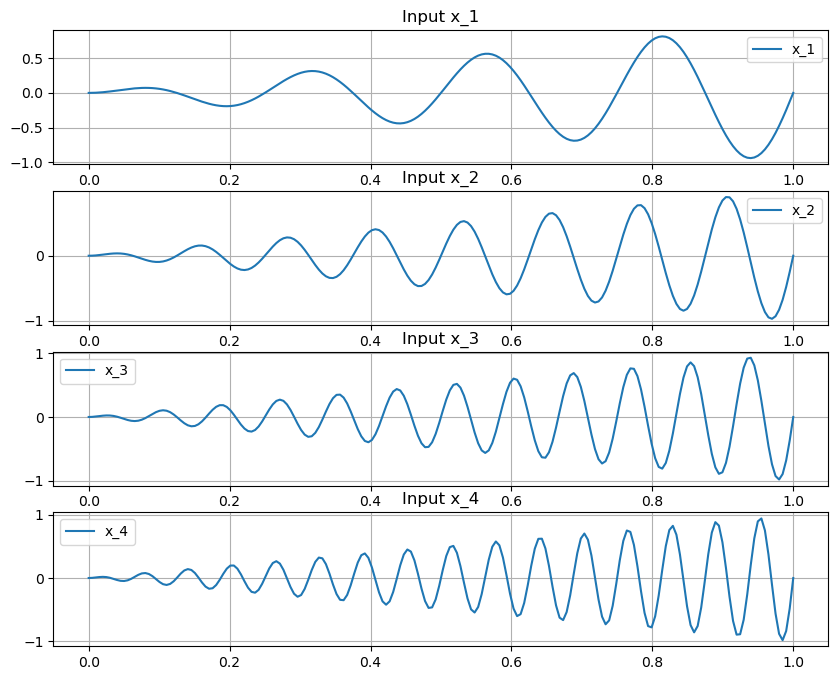

In [33]:
t = torch.linspace(0, 1, N).to(device)
xs = [ t * torch.sin(2 * torch.pi * t * (4*(i+1))) for i in range(Dx) ] # (Dx,N)
x = torch.stack(xs, dim=-1)  # (N, Dx)
x = torch.unsqueeze(x,0)
x = x.repeat(B, 1, 1)  # (B, N, Dx)

t = t.unsqueeze(0).repeat(B, 1)  # (B, N)

print(f"t shape: {t.shape}")  # (B, N)
print(f"Input shape: {x.shape}")  # (B, N, Dx)

if Dx > 1:
    fig, axs = plt.subplots(Dx, 1, figsize=(10, 2 * Dx))
    for i in range(Dx):
        axs[i].plot(t[0].cpu().numpy(), x[0, :, i].cpu().numpy(), label=f"x_{i+1}")
        axs[i].set_title(f"Input x_{i+1}")
        axs[i].legend()
        axs[i].grid()
else:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(t[0].cpu().numpy(), x[0, :, 0].cpu().numpy(), label="x_1")
    ax.set_title("Input x_1")
    ax.legend()
    ax.grid()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Training
</div>

Torch Encode and Decoder compoenents

In [51]:
encoder_mean = EncoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=256,
    activation=nn.Tanh,
).to(device)

print(encoder_mean)

encoder_precision = EncoderPrecision(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=256,
    activation=nn.Tanh, 
    epsilon=1e-12
).to(device)

print(encoder_precision)

encoder_covariance = EncoderCovariance(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=256,
    activation=nn.Tanh,
    epsilon=1e-12
).to(device)

print(encoder_covariance)

decoder_mean = DecoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=64,
    activation=nn.ReLU,
).to(device)

print(decoder_mean)

# decoder_logvar = make_mlp(
#     input_dim=Dz,
#     output_dim=Dx,
#     n_layers=4,
#     inter_dim=64,
#     activation=nn.Tanh,
# ).to(device)

decoder_covariance = DecoderCovariance(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=64,
    activation=nn.ReLU,
    epsilon=1e-12,
).to(device)

print(decoder_covariance)

# print(f"Decoder log variance MLP: {decoder_logvar}")
# # print(decoder_logvar)

EncoderMean, x_dimension=4, z_dimension=1, n_layers=4, inter_dim=256, activation=Tanh
EncoderPrecision(x_dimension=4, z_dimension=1, n_layers=4, inter_dim=256, activation=Tanh, epsilon=1e-12)
EncoderCovariance : (x_dimension=4, z_dimension=1, n_layers=4, inter_dim=256, activation=Tanh, epsilon (to ensure PSD)=1.000e-12)
DecoderMean x_dimension=4, z_dimension=1, n_layers=4, inter_dim=64, activation=ReLU
DecoderCovariance : (x_dimension=4, z_dimension=1, n_layers=4, inter_dim=64, activation=ReLU, epsilon (to ensure PSD)=1.000e-12)


Gaussian Process priors

In [52]:
kernels_list = []
mean_functions_list = []

for i in range(Dz):
    # kernel = GaussianKernel(lengthscale=1 / 2**i, sigma=1.0, epsilon=1e-12)
    kernel = GaussianKernel(lengthscale=0.1, sigma=1.0, epsilon=1e-12).to(device)
    kernels_list.append(kernel)
    # mean_function = GPNullMean()
    mean_function = GPConstantMean(constant_init=0.0).to(device)
    mean_functions_list.append(mean_function)

In [53]:
def compute_p_theta_z(t, kernels_list, mean_functions_list, verbose=False):
    """ Compute the Gaussian Process prior p_theta_z for each kernel and mean function.
    This function is used at each training step as the parameters of the kernels and mean functions are updated.
    """
    
    kernel_matrices = []
    L_matrices = []
    means = []

    for i in range(Dz):
        
        mu_z_i = mean_functions_list[i](t)  # (B, N)
        kernel_matrix_i, L_i = kernels_list[i](t, t)

        kernel_matrices.append(kernel_matrix_i)  # (B, N, N)
        L_matrices.append(L_i)  # (B, N, N) or None
        means.append(mu_z_i)  # (B, N)
        
        if verbose:
            print()
            print(f"Computing Gaussian Process prior for z component {i+1} / {Dz}...")
            print(f"Kernel {i} is : {kernels_list[i]}")
            print(f"Mean function {i} is : {mean_functions_list[i]}")
            print(f"mu_z_i shape (B,N): {mu_z_i.shape}")  # (B, N)
            print(f"Kernel matrix {i} shape (B,N,N): {kernel_matrix_i.shape}")  # (B, N, N)
        
    kernel_matrix = torch.stack(kernel_matrices, dim=0)  # (Dz, B, N, N)
    kernel_matrix = kernel_matrix.transpose(0, 1) # (B, Dz, N, N)
    L_matrix = torch.stack(L_matrices, dim=0) if L_matrices[0] is not None else None  # (Dz, B, N, N) or None
    L_matrix = L_matrix.transpose(0, 1) if L_matrix is not None else None  # (B, Dz, N, N)
    mean = torch.stack(means, dim=0)  # (Dz, B, N)
    mean = mean.transpose(0, 1)  # (B, Dz, N)
    
    if verbose:
        print()
        print(f"Kernel matrix shape after stack and transpose: {kernel_matrix.shape}")  # (Dz, B, N, N)
        print(f"L matrix shape after stack transpose: {L_matrix.shape if L_matrix is not None else 'None'}")  # (B, Dz, N, N) or None
        print(f"Mean shape after transpose: {mean.shape}")  # (B, Dz, N)

    p_theta_z = torch.distributions.MultivariateNormal(
        loc=mean,  # (B, Dz, N)
        scale_tril=L_matrix,  # (B, Dz, N, N)
    )
    if verbose:
        print()
        print(f"p_theta_z: {p_theta_z}")
        print(f"\tp_theta_z batch shape: {p_theta_z.batch_shape}")  # (B, Dz)
        print(f"\tp_theta_z event shape: {p_theta_z.event_shape}")  # (N)

    return p_theta_z, kernel_matrix, L_matrix, mean

Training setup

In [54]:
kernel_parameters = [ param for kernel in kernels_list for param in kernel.parameters() ]
mean_functions_parameters = [ param for mean_function in mean_functions_list for param in mean_function.parameters() ]

optimizer = torch.optim.Adam(
    list(encoder_mean.parameters()) + list(encoder_precision.parameters()) + list(encoder_covariance.parameters()) +
    list(decoder_mean.parameters()) + list(decoder_covariance.parameters()) +
    kernel_parameters +
    mean_functions_parameters,
    lr = 1e-3
)

In [55]:
losses = []
kls = []
reconstruction_losses = []

# dictionnary to store the parameters of the prior Gaussian Processes
mean_parameters_values = {}  # to store mean parameters if any
for i in range(Dz):
    mean_parameters_values[f"mean_function_{i}"] = {}
    mean_function = mean_functions_list[i]
    for name, param in mean_function.named_parameters():
        mean_parameters_values[f"mean_function_{i}"][name] = []
    
kernels_parameters_values = {}  # to store kernel parameters if any
for i in range(Dz):
    kernels_parameters_values[f"kernel_{i}"] = {}
    kernel = kernels_list[i]
    for name, param in kernel.named_parameters():
        kernels_parameters_values[f"kernel_{i}"][name] = []

In [56]:
if len(kernel_parameters) == 0 and len(mean_functions_parameters) == 0:
    learnable_kernel = False
    print("Prior kernels are fixed (no learnable parameters).")
else:
    learnable_kernel = True
    if len(kernel_parameters) > 0:
        print("Prior kernels are learnable (has learnable parameters).")
        print(kernels_parameters_values)
    if len(mean_functions_parameters) > 0:
        print("Prior mean functions are learnable (has learnable parameters).")
        print(mean_parameters_values)

Prior kernels are learnable (has learnable parameters).
{'kernel_0': {'lengthscale': [], 'sigma': []}}
Prior mean functions are learnable (has learnable parameters).
{'mean_function_0': {'constant_value': []}}


In [57]:
# initialize prior Gaussian Processes
# can be done once before the training loop if there are no learnable parameters

p_theta_z, kernel_matrix, L_matrix, mean = compute_p_theta_z(t, kernels_list, mean_functions_list, verbose=True)


Computing Gaussian Process prior for z component 1 / 1...
Kernel 0 is : GaussianKernel(lengthscale=1.000e-01, variance (sigma**2)=1.000e+00, sigma=1.000e+00, epsilon=1.000e-12)
Mean function 0 is : GPConstantMean, constant_value=0.000e+00)
mu_z_i shape (B,N): torch.Size([1, 200])
Kernel matrix 0 shape (B,N,N): torch.Size([1, 200, 200])

Kernel matrix shape after stack and transpose: torch.Size([1, 1, 200, 200])
L matrix shape after stack transpose: torch.Size([1, 1, 200, 200])
Mean shape after transpose: torch.Size([1, 1, 200])

p_theta_z: MultivariateNormal(loc: torch.Size([1, 1, 200]), scale_tril: torch.Size([1, 1, 200, 200]))
	p_theta_z batch shape: torch.Size([1, 1])
	p_theta_z event shape: torch.Size([200])


In [58]:
N_EPOCHS = int(5e+3)
K = 10

N = t.size(-1)  # number of time points
epsilon = 1e-12
tolerance = epsilon * torch.eye(N).to(device)

x_rec = torch.unsqueeze(x,0).repeat(K,1,1,1)

print(f"x_rec shape (K,B,N,Dx) for reconstruction loss computation : {x_rec.shape}")  # (K, B, N, Dx)

x_rec shape (K,B,N,Dx) for reconstruction loss computation : torch.Size([10, 1, 200, 4])


In [59]:
for epoch in range(N_EPOCHS):
       
    # PRIOR pass --------------------------------------------------------------
    # if the kernel is learnable, we need to recompute the prior mean and kernel at each epoch
    if learnable_kernel:
        p_theta_z, kernel_matrix, L_matrix, mean = compute_p_theta_z(t, kernels_list, mean_functions_list, verbose=False)

    # ENCODER pass ------------------------------------------------------------
    # encode mean
    mu_phi = encoder_mean(x)  # (B, Dz, N)
    # encode precision or covariance
    # --- choice 1 : with precision matrix
    # _, _, precision_phi = encoder_precision(x)  # (B, Dz, N, N)
    # precision_phi = precision_phi  # (B, Dz, N, N)
    # q_phi = torch.distributions.MultivariateNormal(
    #     loc=mu_phi,  # (B, Dz, N)
    #     precision_matrix=precision_phi,  # (B, Dz, N, N)
    # )
    # -- choice 2 : with covariance matrix
    L_phi, covariance_phi = encoder_covariance(x)  # (B, Dz, N, N)
    covariance_phi = covariance_phi.squeeze(0)  # (B, Dz, N, N)
    # L_phi = L_phi.squeeze(0)  # (Dz, N, N)

    q_phi = torch.distributions.MultivariateNormal(
        loc=mu_phi,  # (B, Dz, N)
        scale_tril=L_phi,  # (B, Dz, N, N)
    )

    # DECODER pass ------------------------------------------------------------    
    # sample z
    z_sampled = q_phi.rsample((K,)) # (K, B, Dz, N)
    z_sampled_p = z_sampled.transpose(-1, -2)  # (K, B, N, Dz)
    
    # decode
    mu_x = decoder_mean(z_sampled_p)  # (K,B,N,Dx)
    L_x, covar_x = decoder_covariance(z_sampled_p) # + tolerance # (K,B,N,Dx,Dx)

    p_theta_x = torch.distributions.MultivariateNormal(
        loc=mu_x,
        scale_tril=L_x
    ) # batch_shape=(K,B,Dx), event_shape=(N,)
    # print(f"p_theta_x: {p_theta_x}")
    # print(f"\tp_theta_x batch shape: {p_theta_x.batch_shape}")  # (K,B,N)
    # print(f"\tp_theta_x event shape: {p_theta_x.event_shape}")  # (Dx,)
       
    # LOSS computation --------------------------------------------------------
    # compute loss
    kl = torch.distributions.kl_divergence(q_phi, p_theta_z).sum(-1).mean()  # (B,Dz,N) => scalar
    reconstruction_loss = p_theta_x.log_prob(x_rec).sum(-1).mean() # (K,B,N) => scalar
    # reconstruction_loss = p_theta_x.log_prob(x_rec).mean()
    loss = -reconstruction_loss + kl
        
    # optimization step
    optimizer.zero_grad()
    loss.backward()  
    optimizer.step()
    
    # log losses
    losses.append(loss.item())
    kls.append(kl.mean().item())
    reconstruction_losses.append(-reconstruction_loss.mean().item())
    
    # record parameters
    for i in range(Dz):
        # record mean function parameters
        mean_function = mean_functions_list[i]
        for name, param in mean_function.named_parameters():
            mean_parameters_values[f"mean_function_{i}"][name].append(param.item())
        # record kernel parameters
        kernel = kernels_list[i]
        for name, param in kernel.named_parameters():
            kernels_parameters_values[f"kernel_{i}"][name].append(param.item())
        
    # print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1:>6}/{N_EPOCHS:>6}], Loss: {loss.item():.4e}, "
              f"KL: {kl.mean().item():.4e}, "
              f"Reconstruction Loss (avg over {K} sample(s)): {-reconstruction_loss.mean().item():.4e}")

Epoch [     1/  5000], Loss: 9.9405e+13, KL: 9.9405e+13, Reconstruction Loss (avg over 10 sample(s)): 8.2936e+02
Epoch [    10/  5000], Loss: 1.9843e+12, KL: 1.9843e+12, Reconstruction Loss (avg over 10 sample(s)): 7.0697e+02
Epoch [    20/  5000], Loss: 4.0104e+11, KL: 4.0104e+11, Reconstruction Loss (avg over 10 sample(s)): 5.1982e+02
Epoch [    30/  5000], Loss: 5.2261e+10, KL: 5.2261e+10, Reconstruction Loss (avg over 10 sample(s)): 4.3953e+02
Epoch [    40/  5000], Loss: 3.7708e+10, KL: 3.7708e+10, Reconstruction Loss (avg over 10 sample(s)): 4.2013e+02
Epoch [    50/  5000], Loss: 2.0585e+09, KL: 2.0585e+09, Reconstruction Loss (avg over 10 sample(s)): 4.1582e+02
Epoch [    60/  5000], Loss: 2.2743e+09, KL: 2.2743e+09, Reconstruction Loss (avg over 10 sample(s)): 4.1585e+02
Epoch [    70/  5000], Loss: 7.0095e+08, KL: 7.0095e+08, Reconstruction Loss (avg over 10 sample(s)): 4.1490e+02
Epoch [    80/  5000], Loss: 3.1820e+08, KL: 3.1820e+08, Reconstruction Loss (avg over 10 sample

Total Loss final: 1.1764e+07
KL Divergence final: 1.1764e+07
Reconstruction Loss (avg over 10 sample(s)) final: 1.5430e+02


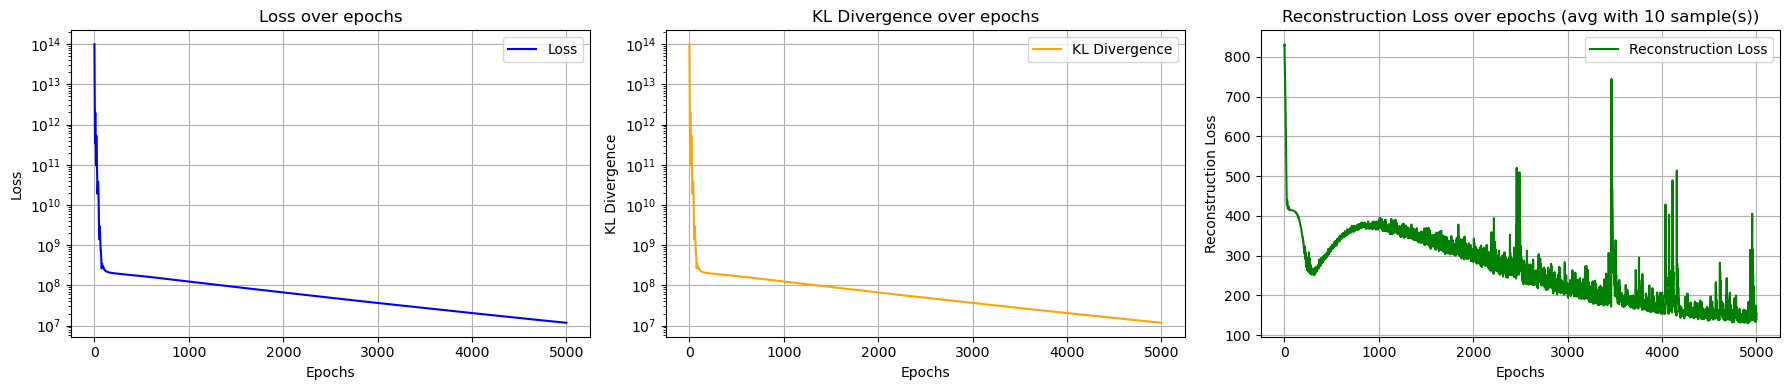

In [60]:
def report_out_losses(losses, kls, reconstruction_losses):
    """ Report the losses and KL divergence.
    """
    
    print(f"Total Loss final: {losses[-1]:.4e}")
    print(f"KL Divergence final: {kls[-1]:.4e}")
    print(f"Reconstruction Loss (avg over {K} sample(s)) final: {reconstruction_losses[-1]:.4e}")

    fig, ax = plt.subplots(1,3, figsize=(18, 4))

    ax[0].plot(losses, label='Loss', color='blue')
    ax[0].set_title('Loss over epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_yscale('log')
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(kls, label='KL Divergence', color='orange')
    ax[1].set_title('KL Divergence over epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('KL Divergence')
    ax[1].set_yscale('log')
    ax[1].grid(True)
    ax[1].legend()

    ax[2].plot(reconstruction_losses, label='Reconstruction Loss', color='green')
    ax[2].set_title(f'Reconstruction Loss over epochs (avg with {K} sample(s))')
    ax[2].set_xlabel('Epochs')      
    ax[2].set_ylabel('Reconstruction Loss')
    ax[2].grid(True)
    ax[2].legend()

    plt.tight_layout()
    plt.show()
    
report_out_losses(losses, kls, reconstruction_losses)

In [61]:
def report_out_parameters(mean_parameters_values, kernels_parameters_values):
    """ Report the parameters of the prior Gaussian Processes.
    """
    
    print("Final Mean function parameters:")
    for i in range(Dz):
        print(f"Mean function {i}:")
        for name, values in mean_parameters_values[f"mean_function_{i}"].items():
            print(f"\t{name}: {values[-1]:.4e}")
            
    for i in range(Dz):
        mean_f = mean_functions_list[i]
        for name, param in mean_f.named_parameters():
            values = mean_parameters_values[f"mean_function_{i}"][name]
            fig, ax = plt.subplots(figsize=(6, 3))
            ax.plot(values, label=f"{name} (Mean function {i})")
            ax.set_title(f"Mean function {i} - {name} over epochs")
            ax.set_xlabel('Epochs')
            ax.set_ylabel(name)
            ax.grid(True)
            ax.legend()
            plt.show()
    
    print("\nFinal Kernel parameters:")
    for i in range(Dz):
        print(f"Kernel {i}:")
        for name, values in kernels_parameters_values[f"kernel_{i}"].items():
            print(f"\t{name}: {values[-1]:.4e}")
            
    for i in range(Dz):
        kernel = kernels_list[i]
        for name, param in kernel.named_parameters():
            values = kernels_parameters_values[f"kernel_{i}"][name]
            fig, ax = plt.subplots(figsize=(6, 3))
            ax.plot(values, label=f"{name} (Kernel {i})")
            ax.set_title(f"Kernel {i} - {name} over epochs")
            ax.set_xlabel('Epochs')
            ax.set_ylabel(name)
            ax.grid(True)
            ax.legend()
            plt.show()

Final Mean function parameters:
Mean function 0:
	constant_value: 3.1376e-02


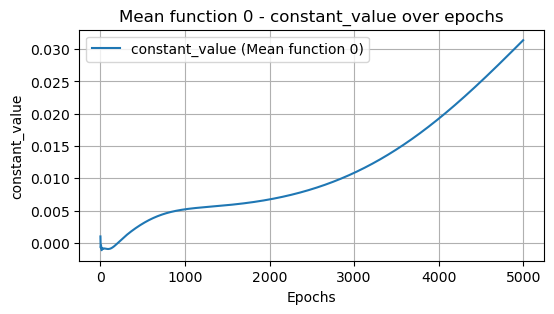


Final Kernel parameters:
Kernel 0:
	lengthscale: 8.7519e-02
	sigma: 1.0118e+00


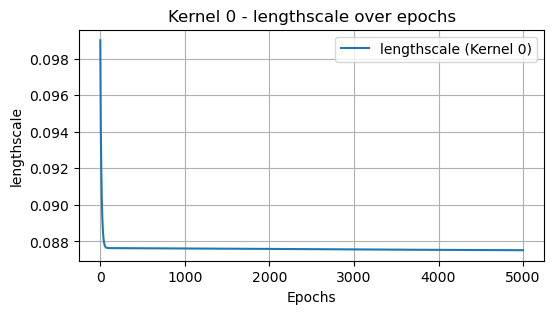

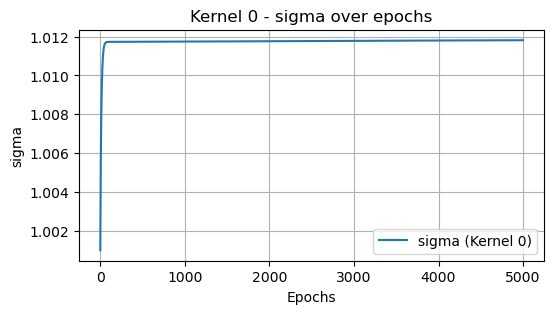

In [62]:
report_out_parameters(mean_parameters_values, kernels_parameters_values)

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Predictions
</div>

In [63]:
z_sampled = q_phi.rsample()  # (B, Dz, N)
z_sampled_p = z_sampled.transpose(-1, -2)  # (B, N, Dz)
print(f"z_sampled shape: {z_sampled.shape}")

z_sampled shape: torch.Size([1, 1, 200])


In [64]:
with torch.no_grad():
    # Decode the sampled z
    mu_x = decoder_mean(z_sampled_p)  # (B, N, Dx)
    L_x, covar_x = decoder_covariance(z_sampled_p) # + tolerance # (B, N, Dx, Dx)

    p_theta_x = torch.distributions.MultivariateNormal(
            loc=mu_x,
            scale_tril=L_x
    ) # batch_shape=(B, N), event_shape=(Dx,)

    print(f"p_theta_x: {p_theta_x}")
    print(f"\tp_theta_x batch shape: {p_theta_x.batch_shape}")
    print(f"\tp_theta_x event shape: {p_theta_x.event_shape}")

p_theta_x: MultivariateNormal(loc: torch.Size([1, 200, 4]), scale_tril: torch.Size([1, 200, 4, 4]))
	p_theta_x batch shape: torch.Size([1, 200])
	p_theta_x event shape: torch.Size([4])


In [65]:
x_hat = p_theta_x.rsample()  # (B, N, Dx)
print(f"x_hat shape: {x_hat.shape}")  # (B, N, Dx)

x_hat shape: torch.Size([1, 200, 4])


In [66]:
mu_x.size()

torch.Size([1, 200, 4])

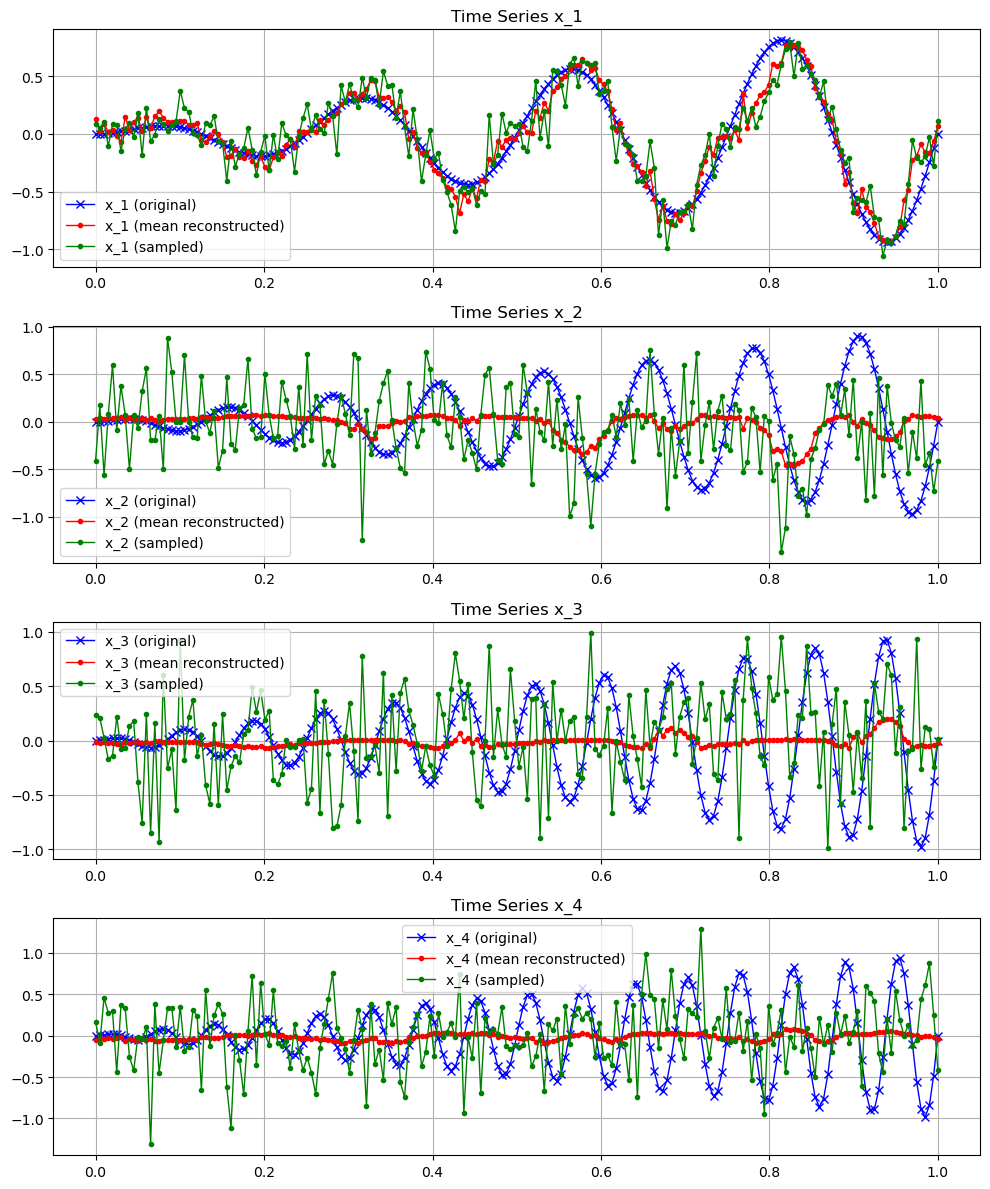

In [67]:
id_in_batch = 0  # Index of the time serie to plot is the batch to plot

if Dx > 1:
    fig, axs = plt.subplots(Dx, 1, figsize=(10, 3 * Dx))
    for i in range(Dx):
        axs[i].plot(t[0].cpu().numpy(), x[id_in_batch, :, i].cpu().numpy(), label=f"x_{i+1} (original)", color='blue', marker='x', linewidth=1)
        axs[i].plot(t[0].cpu().numpy(), mu_x[id_in_batch, :, i].cpu().numpy(), label=f"x_{i+1} (mean reconstructed)", color='red', marker='.', linewidth=1)
        axs[i].plot(t[0].cpu().numpy(), x_hat[id_in_batch, :, i].cpu().numpy(), label=f"x_{i+1} (sampled)", color='green', marker='.', linewidth=1)
        axs[i].set_title(f"Time Series x_{i+1}")
        axs[i].legend()
        axs[i].grid()
else:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(t[0].cpu().numpy(), x[id_in_batch, :, i].cpu().numpy(), label="x_1 (original)", color='blue', marker='x', linewidth=1)
    ax.plot(t[0].cpu().numpy(), mu_x[id_in_batch, :, i].cpu().numpy(), label="x_1 (mean reconstructed)", color='red', marker='.', linewidth=1)
    ax.plot(t[0].cpu().numpy(), x_hat[id_in_batch, :, i].cpu().numpy(), label="x_1 (sampled)", color='green', marker='.', linewidth=1)
    ax.set_title("Time Series x_1")
    ax.legend()
    ax.grid()
    
fig.tight_layout()
plt.show()